In [1]:
from pennylane import numpy as np  
import matplotlib.pyplot as plt  
from VarQFT import * 
import numpy  

In [2]:
a = 0.075
b = -1
c = 1.51449537
m = 1/2

(-6.0, 6.0)

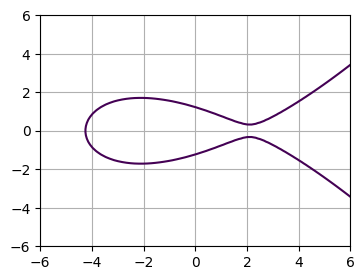

In [3]:
y, x = numpy.ogrid[-8:8:100j, -8:8:100j]
plt.figure( figsize=(4,3) )
plt.contour( x.ravel(), y.ravel(), 
            y**2 - a*x**3 - b *x  - c, [0] )
plt.grid()
plt.xlim( -6, 6)
plt.ylim( -6, 6)

In [4]:
num_qubits = 6

In [5]:
dev = qml.device( "lightning.qubit", 
                    wires=num_qubits)

varqft = VarFourier( num_qubits,
                    lambda x : (-a*x**3 - b*x - c ),
                    lambda p : p**2/(2*m),
                    dev,
                    xmin=-8,
                    xmax= 8
                    ) 

In [6]:
xs, ps = varqft.grid_op()
X_op = varqft.matrix_X() 
P_op = varqft.matrix_P()
vals, vecs = varqft.energy_eigens()
min_state = vecs[:,0] 
idex_min = np.argmin(np.abs(vals))
state     = vecs[:,idex_min] 
idex_min, vals[idex_min] 

(7, -3.1990805476951798e-09)

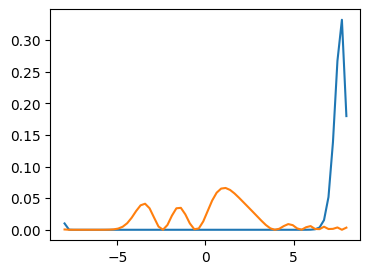

In [7]:
plt.figure( figsize=(4,3) )
plt.plot( xs, np.abs(min_state)**2 )
plt.plot( xs, np.abs(state)**2 )

In [8]:
rho =np.outer( state, state.conj() )
d = 2 ** num_qubits

def Wigner(rho):
    W = np.zeros( (d, d), dtype=complex )
    for m, p in enumerate(ps):
        for mu, x in enumerate( xs ):
            for n, y in enumerate( xs ):
                W[m,mu] += np.exp(4j*np.pi*n*mu/d) \
                            * rho[(m-n)%d,(m+n)%d] / d
    return W

W = Wigner( rho )

In [9]:
def plot_wigner(W):
        plt.figure( figsize=(4,3) )
        plt.imshow( W.real.T, 
                        extent=[xs.min(), xs.max(), 
                                ps.min(), ps.max()],
                        cmap = 'RdBu',
                        interpolation='nearest', 
                        origin='lower', 
                        aspect='auto',
                        vmin=-np.max(np.abs(W)),
                        vmax=np.max(np.abs(W)) )
        plt.colorbar()
        plt.xlim(-8,8)
        plt.ylim(-8,8)
        y, x = numpy.ogrid[-8:8:100j, -8:8:100j]
        plt.contour( x.ravel(), y.ravel(), 
                        y**2 - a*x**3 - b *x  - c, 
                        [0], colors='black' ) 

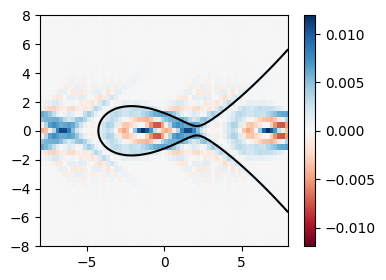

In [10]:
plot_wigner(W)

In [11]:
ec = lambda x : ( x, np.sqrt( a*x**3 + b*x  + c ) )
# A = ec(4*(-1+2*np.random.rand()))
# B = ec(4*(-1+2*np.random.rand()))
A = ec( 5 )
B = ec( 1 )

s  = ( A[1]-B[1] ) / ( A[0]-B[0] )
xc = s**2/a - B[0] - A[0]
yc = s * xc + A[1] - s * A[0] 
C  = ( xc, yc )
theta = np.arctan( s ) +np.pi/2
r     = ( A[1] - s * A[0]) * np.sin( theta )

print('A=',A)
print('B=',B)
print('C=',C)
print('polar=', (r, theta/np.pi) )

A= (5, 2.4268282530908527)
B= (1, 0.7677860183670968)
C= (-3.706315719502338, -1.1842081187825784)
polar= (0.3260898978169389, 0.6251485871324335)


(-6.0, 6.0)

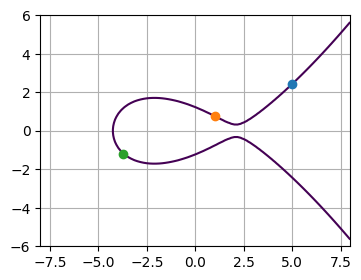

In [12]:
y, x = numpy.ogrid[-8:8:100j, -8:8:100j]
plt.figure( figsize=(4,3) )
plt.contour( x.ravel(), y.ravel(), 
            y**2 - a*x**3 - b *x  - c, [0] )
plt.plot( *A, 'o' )
plt.plot( *B, 'o' )
plt.plot( *C, 'o' )
plt.grid()
plt.xlim( -8, 8)
plt.ylim( -6, 6)

In [13]:
theta = 2*np.pi/3  
Q1 = np.cos(theta)*X_op \
        + np.sin(theta)*P_op 
qs, vecs_q = np.linalg.eigh( Q1 )

mean = r
var  = 0.5
Kraus = np.exp( -0.5*(qs-mean)**2/var )*vecs_q 
Kraus = Kraus @ Kraus.T.conj() 

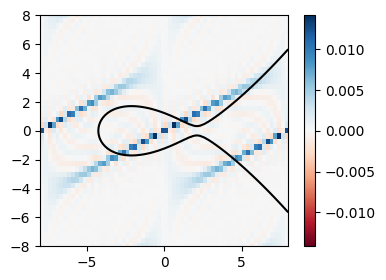

In [14]:
W_post = Wigner( np.outer(vecs_q[:,d//2],vecs_q[:,d//2].conj()) )
plot_wigner(W_post)

In [15]:
state_post = Kraus @ state 
prob_post  = np.linalg.norm(state_post)**2
state_post = state_post / np.linalg.norm( state_post )
W_post = Wigner( np.outer(state_post,state_post.conj()) )

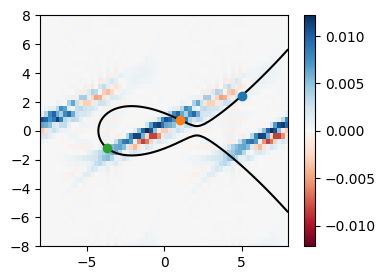

In [16]:
plot_wigner(W_post)
plt.plot( *A, 'o' )
plt.plot( *B, 'o' )
plt.plot( *C, 'o' )

(-8.0, 8.0)

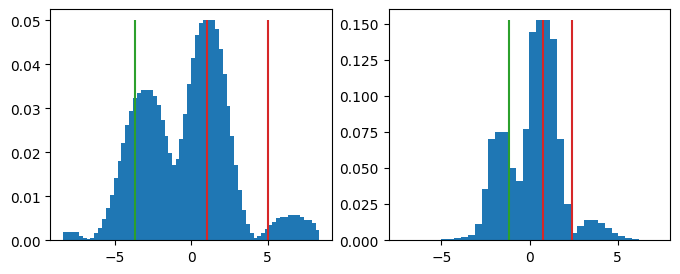

In [17]:
prob_x_post = np.abs(state_post)**2
prob_p_post = np.abs(varqft.Fourier()@state_post)**2

fig, axes = plt.subplots( 1, 2 , figsize=(8,3) )
axes[0].bar( xs, prob_x_post )
axes[0].vlines([A[0],B[0],C[0]],
            0,np.max(prob_x_post),
            color=['tab:red','tab:red','tab:green'])
axes[1].bar( ps, prob_p_post )
axes[1].vlines([A[1],B[1],C[1]],
            0,np.max(prob_p_post),
            color=['tab:red','tab:red','tab:green'])
axes[1].set_xlim( -8, 8 )

In [18]:
( vecs_q.T.conj()@state_post).shape 

(64,)

<BarContainer object of 64 artists>

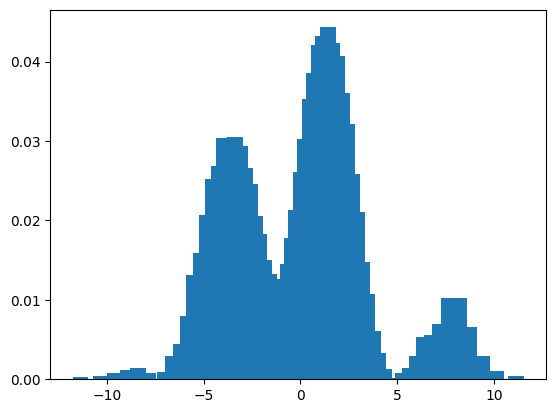

In [19]:
Q2 = np.cos(theta-np.pi/2)*X_op \
        + np.sin(theta-np.pi/2)*P_op 
q2s, vecs_q2 = np.linalg.eigh( Q2 )

probs_Q2 = np.abs( vecs_q2.T.conj()@state_post )**2 

plt.bar( q2s, probs_Q2 )

In [20]:
16/2**8

0.0625